# Hot Plasma I Comparisons

In [125]:
#Import needed modules
import sys
from imp import reload
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 18
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src')
sys.path.append('/home/wtb2/Documents/EBTEL_C/bin')
sys.path.append('/home/wtb2/Documents/sunFM/')
import ebtel_configure as ebc
import ebtel_run as ebr
import ebtel_wrapper as ebw
import ebtel_plot as ebp
import em_binner as emb
reload(ebc)
reload(ebr)
reload(ebw)
reload(ebp)

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1175: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_plot' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_plot.py'>

Compute comparisons for $T,T_{eff}$ plots between Hot Plasma 1 and Hot Plasma 2 papers of Cargill et al., Barnes et al., respectively.

First, have to configure all of the EBTEL options. Note that we have set the heat flux option to __not__ use a flux limiter.

In [126]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 600
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0
config_dict['h_back'] = 3.4e-6
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['heat_species'] = 'electron'

In [127]:
def change_heating(input_dict,tau,q):
    input_dict['t_pulse_half'] = tau/2
    input_dict['h_nano'] = 2*q/tau #triangular heat pulses
    input_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/hp1_compare_tau%.1f_q%.1f'%(tau,q)

First, we'll use the single-fluid EBTEL code to model a single pulse with total energy density 10 erg cm$^{-3}$. The flux limiter has been turned off to be consistent with Paper 1. We'll refer to this as a weak pulse. 

## Weak Pulses, $q=10$ erg cm$^{-3}$

### Ex. 1--$\tau=200$ s

In [128]:
change_heating(config_dict,200,10)

In [129]:
conf = ebc.Configurer(config_dict,'')
conf.print_xml_config(config_file=config_dict['output_file']+'.xml')

In [130]:
ebw.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',
              config_file=config_dict['output_file']+'.xml')

b'************************************************************************************\n            Enthalpy Based Thermal Evolution of Loops (EBTEL)                       \n************************************************************************************\n\nOriginal code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill\nSee Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362\nSee also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174\n\nTranslation into the C Programming Language by Will Barnes,\nDept. of Physics & Astronomy, Rice University (2014)\n************************************************************************************\n\nINPUTS\n------\nTotal time: 600 s\nTime step: 1.000000 s\nLoop half-length: 40.000000 Mm\nUsage option(see documentation): dem\nHeating pulse shape: triangle\nSolving equations using Euler method\nUsing Raymond-Klimchuk Loss Function\nUsing classical method to calculate the heat flux\nUsing new method to

Plot the results quickly.

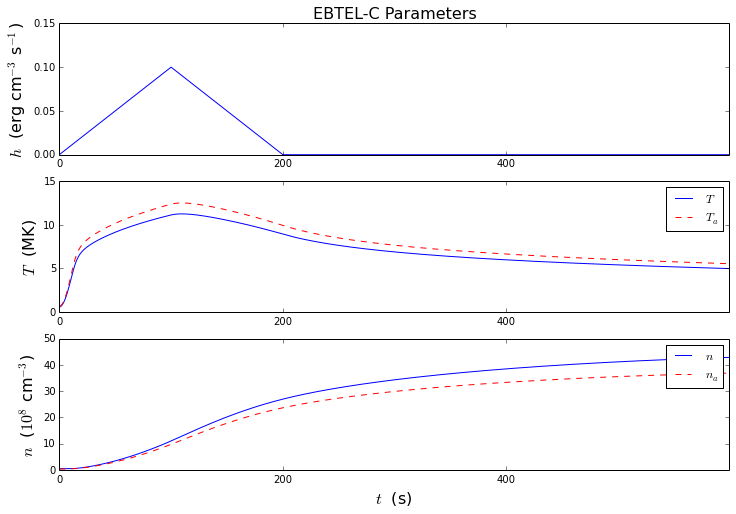

In [131]:
ebw.plot_ebtel('',config_dict['output_file']+'.txt')

Save the data in a format to read by the $T_{eff}$ code.

In [132]:
dat = np.loadtxt(config_dict['output_file']+'.txt')
np.savetxt(config_dict['output_file'] + '_T_n_profile.txt',np.transpose([dat[:,0],dat[:,1],dat[:,2]]),
           header=str(len(dat[:,0])),comments='',fmt='%f\t%e\t%e')

Now, I'll run the $T_{eff}$ code and show the output.

In [133]:
binner = emb.EM_Binner(config_dict['output_file']+'_teff.txt',2*config_dict['loop_length']*10**8)
binner.build_em_dist()

Temperature bins not yet created. Building now with default values.


/home/wtb2/Documents/sunFM/em_binner.py:75: RuntimeWarning: divide by zero encountered in log10
  self.em = np.log10(np.average(em_mat,axis=0,weights=np.gradient(self.time)))
/home/wtb2/Documents/sunFM/em_binner.py:76: RuntimeWarning: divide by zero encountered in log10
  self.em_eff = np.log10(np.average(em_eff_mat,axis=0,weights=np.gradient(self.time)))


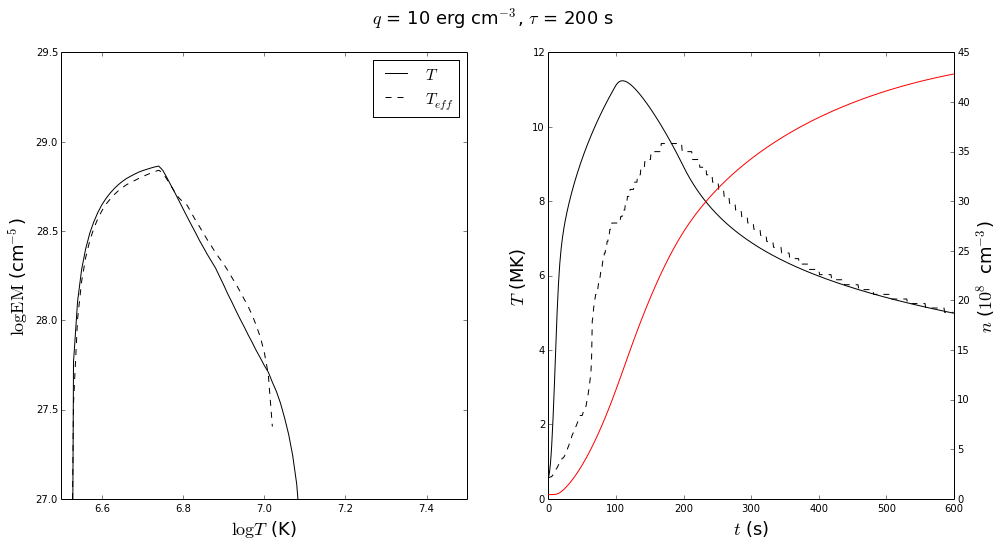

In [134]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(binner.logT_EM,binner.em,'k',label=r'$T$')
ax[0].plot(binner.logT_EM,binner.em_eff,'--k',label=r'$T_{eff}$')
ax[0].set_xlim([6.5,7.5])
ax[0].set_ylim([27,29.5])
ax[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
ax[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
ax[1].plot(binner.time,binner.temp/1e+6,'k')
ax[1].plot(binner.time,binner.temp_eff/1e+6,'--k')
axn = ax[1].twinx()
axn.plot(binner.time,binner.density/1e+8,'r')
axn.set_ylabel(r'$n$ ($10^8$ cm$^{-3}$)',fontsize=18)
ax[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax[1].set_xlabel(r'$t$ (s)',fontsize=18)
fig.suptitle(r'$q$ = %d erg cm$^{-3}$, $\tau$ = %d s'%(config_dict['h_nano']*config_dict['t_pulse_half'],
                                                       2*config_dict['t_pulse_half']),fontsize=18)
ax[0].legend(fontsize=16,loc='best')
plt.show()

### Ex. 2 $\tau=40$ s

In [135]:
change_heating(config_dict,40,10)
conf = ebc.Configurer(config_dict,'')
conf.print_xml_config(config_file=config_dict['output_file']+'.xml')

In [136]:
ebw.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',
              config_file=config_dict['output_file']+'.xml')

b'************************************************************************************\n            Enthalpy Based Thermal Evolution of Loops (EBTEL)                       \n************************************************************************************\n\nOriginal code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill\nSee Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362\nSee also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174\n\nTranslation into the C Programming Language by Will Barnes,\nDept. of Physics & Astronomy, Rice University (2014)\n************************************************************************************\n\nINPUTS\n------\nTotal time: 600 s\nTime step: 1.000000 s\nLoop half-length: 40.000000 Mm\nUsage option(see documentation): dem\nHeating pulse shape: triangle\nSolving equations using Euler method\nUsing Raymond-Klimchuk Loss Function\nUsing classical method to calculate the heat flux\nUsing new method to

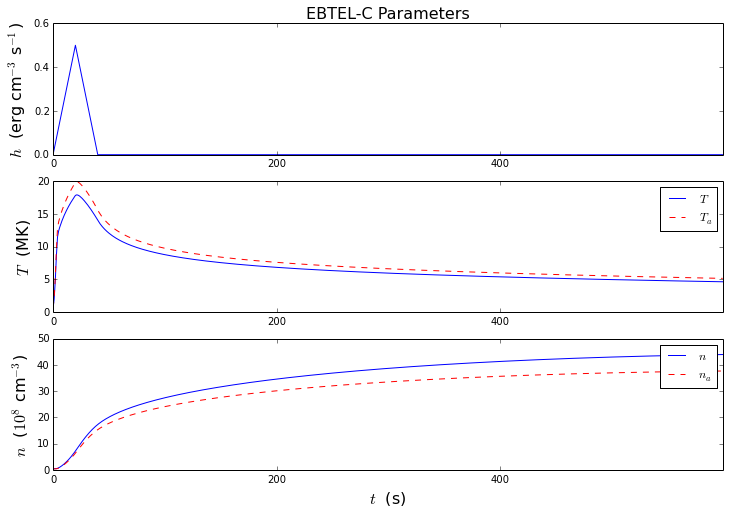

In [137]:
ebw.plot_ebtel('',config_dict['output_file']+'.txt')

In [138]:
dat = np.loadtxt(config_dict['output_file']+'.txt')
np.savetxt(config_dict['output_file'] + '_T_n_profile.txt',np.transpose([dat[:,0],dat[:,1],dat[:,2]]),
           header=str(len(dat[:,0])),comments='',fmt='%f\t%e\t%e')

In [139]:
binner = emb.EM_Binner(config_dict['output_file']+'_teff.txt',2*config_dict['loop_length']*10**8)
binner.build_em_dist()

Temperature bins not yet created. Building now with default values.


/home/wtb2/Documents/sunFM/em_binner.py:75: RuntimeWarning: divide by zero encountered in log10
  self.em = np.log10(np.average(em_mat,axis=0,weights=np.gradient(self.time)))
/home/wtb2/Documents/sunFM/em_binner.py:76: RuntimeWarning: divide by zero encountered in log10
  self.em_eff = np.log10(np.average(em_eff_mat,axis=0,weights=np.gradient(self.time)))


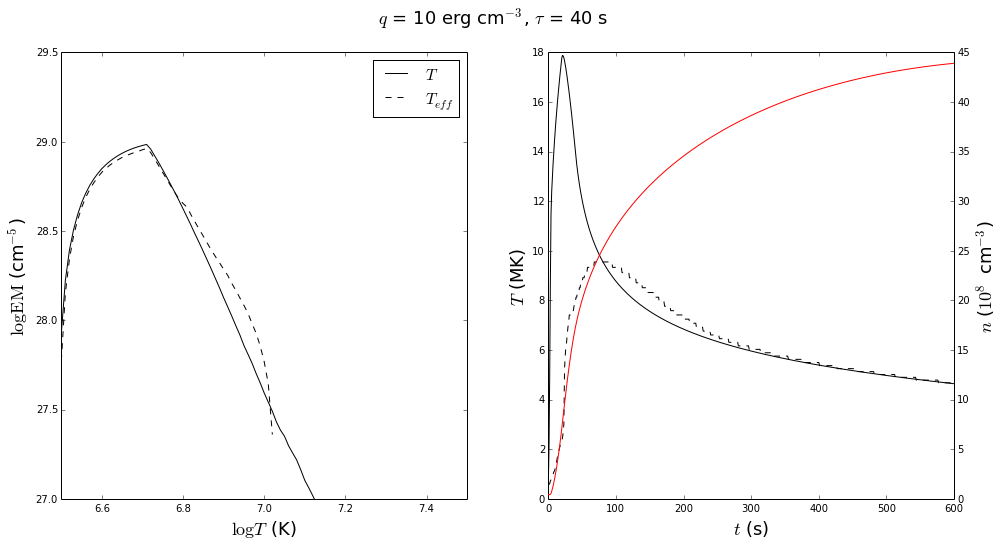

In [140]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(binner.logT_EM,binner.em,'k',label=r'$T$')
ax[0].plot(binner.logT_EM,binner.em_eff,'--k',label=r'$T_{eff}$')
ax[0].set_xlim([6.5,7.5])
ax[0].set_ylim([27,29.5])
ax[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
ax[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
ax[1].plot(binner.time,binner.temp/1e+6,'k')
ax[1].plot(binner.time,binner.temp_eff/1e+6,'--k')
axn = ax[1].twinx()
axn.plot(binner.time,binner.density/1e+8,'r')
axn.set_ylabel(r'$n$ ($10^8$ cm$^{-3}$)',fontsize=18)
ax[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax[1].set_xlabel(r'$t$ (s)',fontsize=18)
fig.suptitle(r'$q$ = %d erg cm$^{-3}$, $\tau$ = %d s'%(config_dict['h_nano']*config_dict['t_pulse_half'],
                                                       2*config_dict['t_pulse_half']),fontsize=18)
ax[0].legend(fontsize=16,loc='best')
plt.show()

## Strong Pulses, $q=100$ erg cm$^{-3}$

Now, let's increase the energy per pulse and see how this affects the $\mathrm{EM}$ distribution for both $T$ and $T_{eff}$.

### Ex. 1 $\tau=200$ s

In [141]:
change_heating(config_dict,200,100)
conf = ebc.Configurer(config_dict,'')
conf.print_xml_config(config_file=config_dict['output_file']+'.xml')
ebw.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',
              config_file=config_dict['output_file']+'.xml')

b'************************************************************************************\n            Enthalpy Based Thermal Evolution of Loops (EBTEL)                       \n************************************************************************************\n\nOriginal code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill\nSee Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362\nSee also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174\n\nTranslation into the C Programming Language by Will Barnes,\nDept. of Physics & Astronomy, Rice University (2014)\n************************************************************************************\n\nINPUTS\n------\nTotal time: 600 s\nTime step: 1.000000 s\nLoop half-length: 40.000000 Mm\nUsage option(see documentation): dem\nHeating pulse shape: triangle\nSolving equations using Euler method\nUsing Raymond-Klimchuk Loss Function\nUsing classical method to calculate the heat flux\nUsing new method to

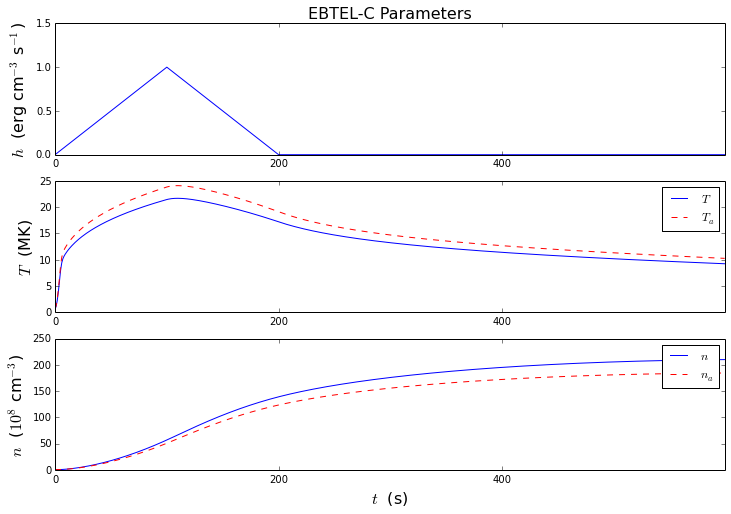

In [142]:
ebw.plot_ebtel('',config_dict['output_file']+'.txt')

In [143]:
dat = np.loadtxt(config_dict['output_file']+'.txt')
np.savetxt(config_dict['output_file'] + '_T_n_profile.txt',np.transpose([dat[:,0],dat[:,1],dat[:,2]]),
           header=str(len(dat[:,0])),comments='',fmt='%f\t%e\t%e')

In [144]:
binner = emb.EM_Binner(config_dict['output_file']+'_teff.txt',2*config_dict['loop_length']*10**8)
binner.build_em_dist()

Temperature bins not yet created. Building now with default values.


/home/wtb2/Documents/sunFM/em_binner.py:75: RuntimeWarning: divide by zero encountered in log10
  self.em = np.log10(np.average(em_mat,axis=0,weights=np.gradient(self.time)))
/home/wtb2/Documents/sunFM/em_binner.py:76: RuntimeWarning: divide by zero encountered in log10
  self.em_eff = np.log10(np.average(em_eff_mat,axis=0,weights=np.gradient(self.time)))


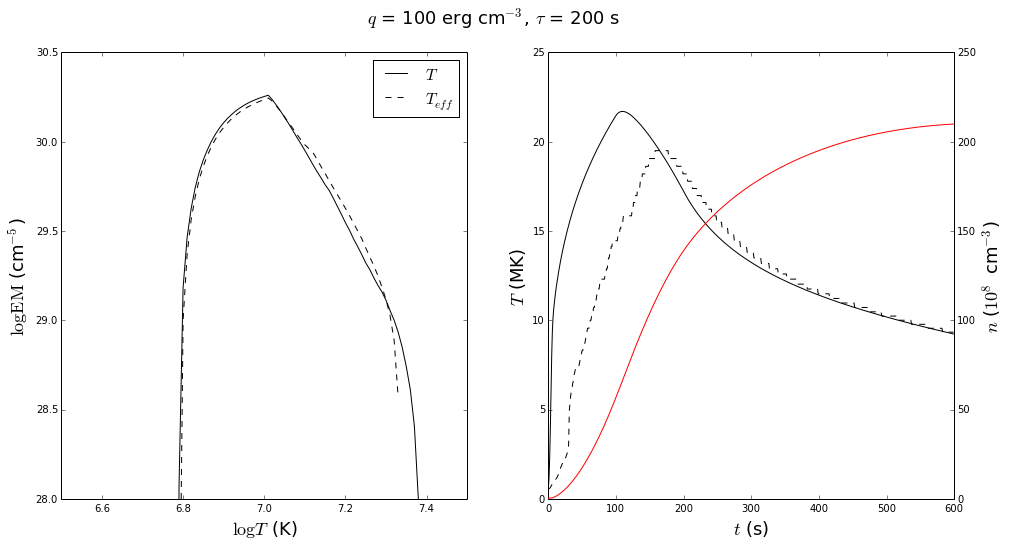

In [145]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(binner.logT_EM,binner.em,'k',label=r'$T$')
ax[0].plot(binner.logT_EM,binner.em_eff,'--k',label=r'$T_{eff}$')
ax[0].set_xlim([6.5,7.5])
ax[0].set_ylim([28,30.5])
ax[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
ax[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
ax[1].plot(binner.time,binner.temp/1e+6,'k')
ax[1].plot(binner.time,binner.temp_eff/1e+6,'--k')
axn = ax[1].twinx()
axn.plot(binner.time,binner.density/1e+8,'r')
axn.set_ylabel(r'$n$ ($10^8$ cm$^{-3}$)',fontsize=18)
ax[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax[1].set_xlabel(r'$t$ (s)',fontsize=18)
fig.suptitle(r'$q$ = %d erg cm$^{-3}$, $\tau$ = %d s'%(config_dict['h_nano']*config_dict['t_pulse_half'],
                                                       2*config_dict['t_pulse_half']),fontsize=18)
ax[0].legend(fontsize=16,loc='best')
plt.show()

### Ex. 2 $\tau=40$ s

In [146]:
change_heating(config_dict,40,100)
conf = ebc.Configurer(config_dict,'')
conf.print_xml_config(config_file=config_dict['output_file']+'.xml')
ebw.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',
              config_file=config_dict['output_file']+'.xml')

b'************************************************************************************\n            Enthalpy Based Thermal Evolution of Loops (EBTEL)                       \n************************************************************************************\n\nOriginal code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill\nSee Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362\nSee also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174\n\nTranslation into the C Programming Language by Will Barnes,\nDept. of Physics & Astronomy, Rice University (2014)\n************************************************************************************\n\nINPUTS\n------\nTotal time: 600 s\nTime step: 1.000000 s\nLoop half-length: 40.000000 Mm\nUsage option(see documentation): dem\nHeating pulse shape: triangle\nSolving equations using Euler method\nUsing Raymond-Klimchuk Loss Function\nUsing classical method to calculate the heat flux\nUsing new method to

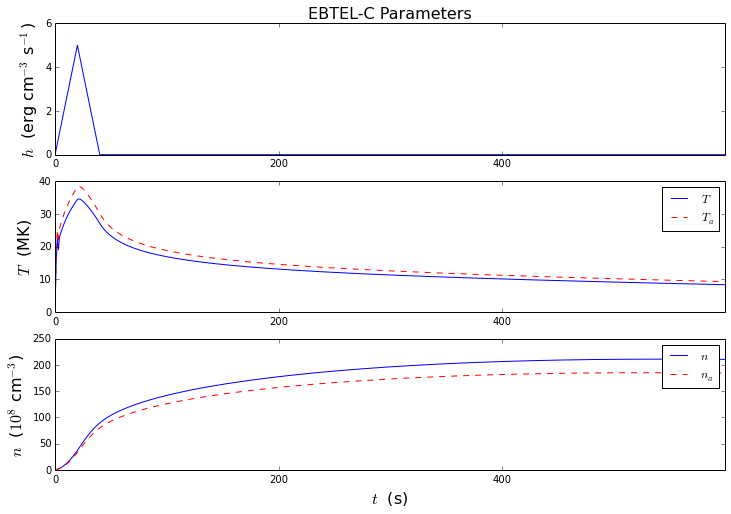

In [147]:
ebw.plot_ebtel('',config_dict['output_file']+'.txt')

In [148]:
dat = np.loadtxt(config_dict['output_file']+'.txt')
np.savetxt(config_dict['output_file'] + '_T_n_profile.txt',np.transpose([dat[:,0],dat[:,1],dat[:,2]]),
           header=str(len(dat[:,0])),comments='',fmt='%f\t%e\t%e')

In [149]:
binner = emb.EM_Binner(config_dict['output_file']+'_teff.txt',2*config_dict['loop_length']*10**8)
binner.build_em_dist()

Temperature bins not yet created. Building now with default values.


/home/wtb2/Documents/sunFM/em_binner.py:75: RuntimeWarning: divide by zero encountered in log10
  self.em = np.log10(np.average(em_mat,axis=0,weights=np.gradient(self.time)))
/home/wtb2/Documents/sunFM/em_binner.py:76: RuntimeWarning: divide by zero encountered in log10
  self.em_eff = np.log10(np.average(em_eff_mat,axis=0,weights=np.gradient(self.time)))


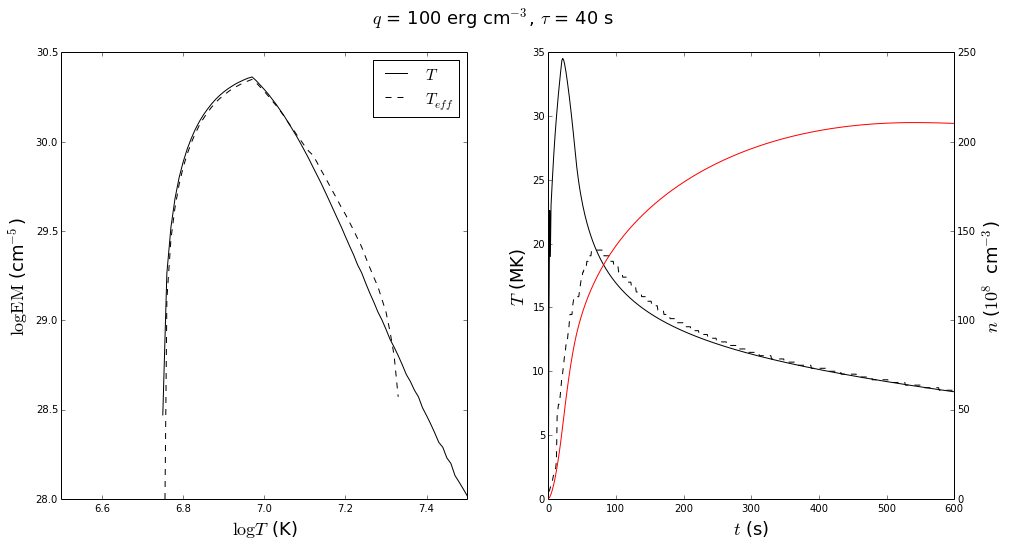

In [150]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(binner.logT_EM,binner.em,'k',label=r'$T$')
ax[0].plot(binner.logT_EM,binner.em_eff,'--k',label=r'$T_{eff}$')
ax[0].set_xlim([6.5,7.5])
ax[0].set_ylim([28,30.5])
ax[0].set_xlabel(r'$\log{T}$ (K)',fontsize=18)
ax[0].set_ylabel(r'$\log{\mathrm{EM}}$ (cm$^{-5}$)',fontsize=18)
ax[1].plot(binner.time,binner.temp/1e+6,'k')
ax[1].plot(binner.time,binner.temp_eff/1e+6,'--k')
axn = ax[1].twinx()
axn.plot(binner.time,binner.density/1e+8,'r')
axn.set_ylabel(r'$n$ ($10^8$ cm$^{-3}$)',fontsize=18)
ax[1].set_ylabel(r'$T$ (MK)',fontsize=18)
ax[1].set_xlabel(r'$t$ (s)',fontsize=18)
fig.suptitle(r'$q$ = %d erg cm$^{-3}$, $\tau$ = %d s'%(config_dict['h_nano']*config_dict['t_pulse_half'],
                                                       2*config_dict['t_pulse_half']),fontsize=18)
ax[0].legend(fontsize=16,loc='best')
plt.show()